In [78]:
# ************* Chapter 图像识别 ********************** #
import numpy as np
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, InputLayer
from keras.layers.convolutional import Conv2D, MaxPooling2D
import sys
sys.path.append("/root/Gan/jidian/MLexperiments")
sys.path.append("/root/Gan/jidian")
import MLexperiments.classes
from MLexperiments.classes import ReadAutoLabeledData
import tensorflow as tf
import MLexperiments.config.parameters
from keras.layers import LSTM, Reshape
import matplotlib.pyplot as plt
import utils
import keras
from keras.callbacks import ModelCheckpoint
import os
from keras.callbacks import TensorBoard
from time import time

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "3,4"


FLAGS = None
myDataSet = utils.read_data_sets(one_hot=True, test_size = 0.1, validation_size = 0.1)

(X_train, y_train), (X_test, y_test) , (X_Ftest, y_Ftest)= (myDataSet.train.images, myDataSet.train.labels), (myDataSet.validation.images, myDataSet.validation.labels), (myDataSet.test.images, myDataSet.test.labels)

print(X_train[0].shape)
print(y_train[0])

X_train = X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
X_test = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1).astype('float32')
#X_train /= 255
#X_test /= 255

def tran_y(y):
    y_ohe = np.zeros(2)
    if y:
        y_ohe[1] = 1
    else:
        y_ohe[0] = 1
    return y_ohe
# def tran_y(y):
#     return y

y_train_ohe = np.array([tran_y(y_train[i]) for i in range(len(y_train))])
y_test_ohe = np.array([tran_y(y_test[i]) for i in range(len(y_test))])




 np_input shape:  (15304, 100, 10) labelData shape:  (15304,)
read succesful
(1000,)
1


In [79]:
model = Sequential()
#model.add(Input(shape=(MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT, 1)))
model.add(
    Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(128, kernel_size=(3, 3), strides=(1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(32, kernel_size=(10, MLexperiments.config.parameters.SAMPLE_HEIGHT - 4), strides=(1, 1), padding='valid', activation='relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5,name="dropout3"))

model.add(Reshape((model.get_layer("dropout3").output_shape[1], model.get_layer("dropout3").output_shape[3]), name = "reshape"))

model.add(LSTM(128))

model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='softmax'))

funcmodel = model.model



model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=['accuracy'])

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        
lossHistory = LossHistory()
checkpointer = ModelCheckpoint(filepath='/tmp/weights.hdf5', verbose=1, save_best_only=True)
tensorboard = TensorBoard(log_dir="logs/{}".format(time()),histogram_freq=1, batch_size=128, write_graph=False, write_grads=False, \
                          write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

model.summary()
#
history = model.fit(X_train, y_train_ohe, validation_data=(X_test, y_test_ohe), epochs=3, batch_size=128, \
                callbacks=[lossHistory, checkpointer,tensorboard] )
# list all data in history

TypeError: __init__() got an unexpected keyword argument 'shape'

history.history.keys():
dict_keys(['val_acc', 'val_loss', 'loss', 'acc'])


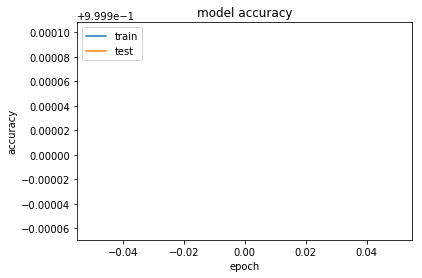

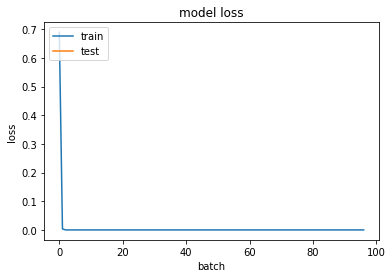

In [63]:
print("history.history.keys():")
print(history.history.keys())

# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(lossHistory.losses)
plt.plot(lossHistory.val_losses)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('batch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

scores = model.evaluate(X_test, y_test_ohe, verbose=0)

expected: 1
prediction:0


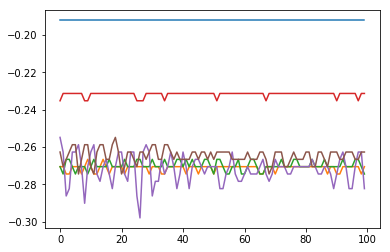

expected: 1
prediction:0


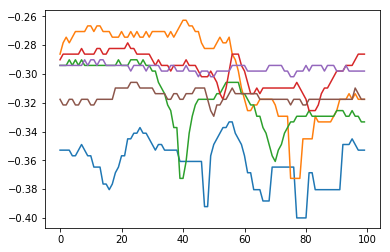

expected: 1
prediction:0


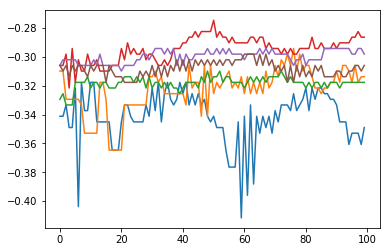

expected: 1
prediction:0


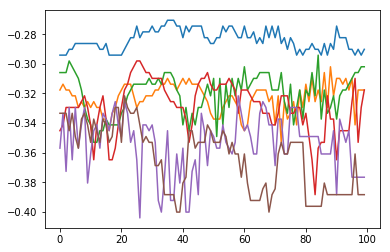

expected: 1
prediction:0


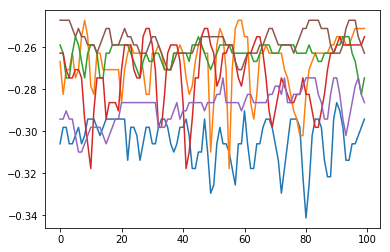

expected: 1
prediction:0


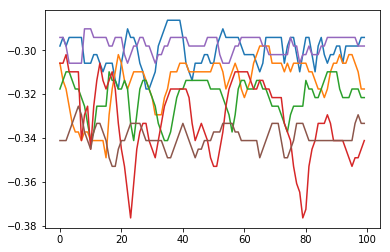

expected: 1
prediction:0


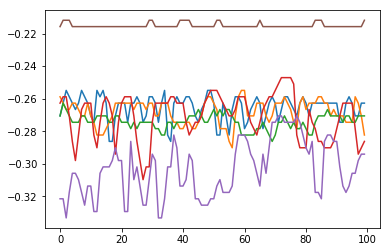

expected: 1
prediction:0


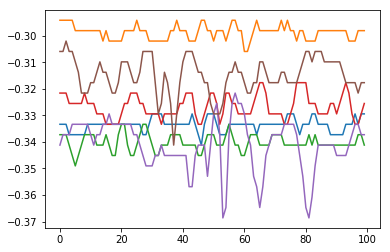

expected: 1
prediction:0


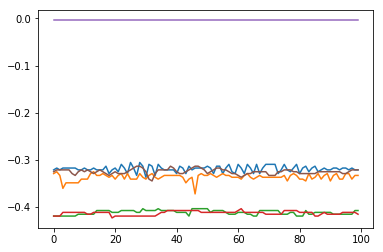

expected: 1
prediction:0


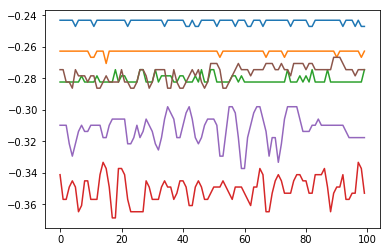

In [58]:
for index in range(10):
    print("expected: "+str( np.argmax(y_test_ohe[index],axis = 0)))
    prediction = model.predict(np.expand_dims(X_test[index], axis=0))[0]
    print("prediction:" + str(np.argmax(prediction,axis = 0)))
    time_series = X_test.reshape(X_test.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT) \
        .astype('float32')[index]
    # plt.imshow( X_train.reshape(X_train.shape[0], MLexperiments.config.parameters.SAMPLE_LEN, MLexperiments.config.parameters.SAMPLE_HEIGHT).astype('float32')[0]);
    # plt.colorbar()
    # plt.show()
    plt.plot(time_series.T[0])
    plt.plot(time_series.T[1])
    plt.plot(time_series.T[2])
    plt.plot(time_series.T[3])
    plt.plot(time_series.T[4])
    plt.plot(time_series.T[5])
    plt.show()
   